In [1]:
# V0. operational
# V1. add feature to allow export of EEG time locations that contain artifact.
#         > first ARF is run, saves artifact locations into pd dataframe which contains, filename of data, 
#         > subsegment number of data, and artifact state


In [2]:
%matplotlib inline

import pickle as pkl
import fnmatch
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import mne
import numpy as np
import os
import pandas as pd
import random
import sys
from glob import glob
from scipy import signal
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.preprocessing import scale

import lightgbm as lgb

import numpy as np

from sklearn.model_selection import StratifiedKFold

import seaborn as sns
sns.set()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn import metrics
from sklearn.preprocessing import StandardScaler


def get_cv(subjects):
    cv = {}
    
    temp_fnames = []
    temp_lbls = []
    temp_anns = []
    temp_idcs = []

    for subject in subjects:
        base = '../data/%s/%s_' % (str(subject).zfill(3), str(subject).zfill(3))
        fnames = sorted(glob(base + '*.h5'),
                        key=lambda x: int(x.replace(base, '')[:-7]))

        fnames_finals = []
        for fname in fnames:
            ba = '../data/%s/' % (str(subject).zfill(3))
            fn = fname.replace(ba, '')
            fnames_finals.append(fn)
        temp_fnames.extend(fnames_finals)

        for fname in fnames_finals:
            temp_lbls.append(int(fname.split('.')[0][-1]))
            anns = int(fname.split('.')[0].split('_')[2])
            #print fname.split('.')[0].split('_')[2]
            temp_anns.append(anns)
            temp_idcs.append(True)

    cv['fnames'] = np.array(temp_fnames)
    cv['labels'] = np.array(temp_lbls)
    cv['anns'] = np.array(temp_anns)
    cv['indices'] = np.array(temp_idcs)

    #print cv
    return cv

/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/mne/fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/mne/fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


In [19]:
ref_chans = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 
    'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'A1', 'A2']  # Note temporal chain has different pattern!

xforms = {
            'original': ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'A1', 'A2'],
#             'leftright': ['Fp2', 'Fp1', 'F4', 'F3', 'C4', 'C3', 'P4' , 'P3', 'O2', 'O1', 'F8', 'F7', 'T4', 'T3', 'T6', 'T5','Fz', 'Cz', 'Pz', 'A2', 'A1'],
#          'postant':    [ 'O1', 'O2', 'T3', 'T4', 'T5', 'T6',  'P4' , 'P3', 'C3', 'C4', 'Fz', 'Cz', 'Pz', 'A1', 'A2', 'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8']
}

xform_map = []
for xfn, xf_lst in xforms.items():
    xform_map.append([ref_chans.index(xf_ch) for xf_ch in xf_lst])


In [20]:
xform_map

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]

In [192]:

subjects = np.array([1, 2, 3, 4])
subjects = np.array([3])
subjects = np.arange(1,64)
# bad_subjects = np.array([17, 21])
# subjects = np.setdiff1d(subjects,bad_subjects)

subjects = sorted(subjects)


# feature_datasets = ['relative_log_power', 'arError', 'stats', 'various']
feature_datasets = ['arError', 'relative_log_power', 'stats']
feature_datasets = ['autocorrmat']

feature_datasets = ['relative_log_power', 'stats', 'rqa_delta_bp' ]
feature_datasets = ['relative_log_power', 'stats' ]
feature_datasets = ['relative_log_power']

cv = get_cv(subjects)

col_names = []
features = []

for jj, feat in enumerate(feature_datasets):    
    print(f"Feature: {feat}")
    temp_features = []
    subjs = []
    for subject in subjects:
        s_file = './features/%s/%s.npz' % (feat, str(subject).zfill(3))
        if not os.path.exists(s_file):
            print(f"{s_file} does not exist!")
            continue
        a = np.load(s_file)
        arr = a['features']
        temp_features.append(arr)
        subjs.extend([subject]*(arr.shape[0]*arr.shape[1]))
    
    if feat == 'rqa_delta_bp':
        temp_features = np.vstack(temp_features)
        print(f'\t\t{feat} shape:', temp_features.shape)

        flat_shape = (temp_features.shape[2] * temp_features.shape[3], )
        temp_features = temp_features.reshape((-1, *flat_shape))
        print('\t:', temp_features.shape)
        features.append(temp_features)
    elif feat == 'rqachan_delta_bp':
        temp_features = np.vstack(temp_features)
        print(f'\t\t{feat} shape:', temp_features.shape)

        xform_features = []
        for xform in xform_map:
            temp_features = np.take(temp_features_copy, xform, axis=2)
            xform_features.append(temp_features)
            
        # Reshape to (180*30, new_shape)
        flat_shape = (temp_features.shape[2] * temp_features.shape[3], )
        temp_features = temp_features.reshape((-1, *flat_shape))
        print('\t:', temp_features.shape)
        features.append(temp_features)
        
    elif feat == 'coherences_transposed':
        # Broken
        print('\t:', temp_features.shape)
    elif feat == 'autocorrmat':
        # Broken
        print('\t:', temp_features.shape)
    elif feat == 'stats':
        # e.g. stats: (70, 30, 21, 6)
        #        (time, 30 twenty second windows = 10 min, 21 channels, 6 stats.)
        temp_features = np.vstack(temp_features)
        temp_features_copy = np.copy(temp_features)
        print(f'\t\t{feat} shape:', temp_features.shape)
        
        xform_features = []
        for xform in xform_map:
            temp_features = np.take(temp_features_copy, xform, axis=2)
            xform_features.append(temp_features)
            
        # Reshape to (180*30, new_shape)
        flat_shape = (temp_features.shape[2] * temp_features.shape[3], )
        temp_features = temp_features.reshape((-1, *flat_shape))
        print('\t:', temp_features.shape)

        features.append(temp_features)
        
    elif feat == 'relative_log_power':
        # e.g. shape already flattened. e.g. (70, 30, 21*6)
        temp_features = np.vstack(temp_features)
        temp_features_copy = np.copy(temp_features)

        print(f'\t\t{feat} shape:', temp_features.shape)
        xform_features = []
        for xform in xform_map:
            temp_features = np.take(temp_features_copy, xform, axis=2)
            xform_features.append(temp_features)

        flat_shape = (temp_features.shape[2] * temp_features.shape[3], )
        temp_features = temp_features.reshape((-1, *flat_shape))
        print('\t:', temp_features.shape)


        features.append(temp_features)
    
    col_names.extend([f'{feat}_{i}' for i in range(temp_features.shape[1])])

# features = np.vstack(features)

print(len(features))


Feature: relative_log_power
./features/relative_log_power/017.npz does not exist!
./features/relative_log_power/021.npz does not exist!
./features/relative_log_power/024.npz does not exist!
./features/relative_log_power/027.npz does not exist!
./features/relative_log_power/040.npz does not exist!
		relative_log_power shape: (5359, 30, 21, 6)
	: (160770, 126)
1


In [193]:
features_arr = np.hstack(features)

In [133]:
features_arr = np.random.rand(*features_arr.shape)


In [194]:

df_train = pd.DataFrame(features_arr, columns=col_names)
df_train['Subject'] = np.array(subjs)
df_train['Subject'] = df_train['Subject'].astype('int')
df_train = df_train.drop(df_train[df_train['Subject']==2].index)
df_train = df_train.drop(df_train[df_train['Subject']==62].index)

In [195]:
df = pd.read_csv('data/SPQR_clinFeats_20190419.csv')
df = df.rename({'Unnamed: 0': 'Subject', 'Latency (NR)':'Latency - NR'}, axis='columns')

df_resp = df.copy()
df_resp = df_resp[['Subject', 'Class', 'Age(resp)', 'Latency - R']]
df_resp = df_resp[df_resp['Class'] == 0.]
df_resp = df_resp.rename({'Latency - R':'Latency', 'Age(resp)': 'Age'}, axis='columns')
df_nresp = df.copy()
df_nresp = df_nresp[['Subject', 'Class', 'Age(non-resp)', 'Latency - NR']]
df_nresp = df_nresp[df_nresp['Class'] ==1.]
df_nresp = df_nresp.rename({'Latency - NR':'Latency', 'Age(non-resp)': 'Age'}, axis='columns')

df_all = pd.concat([df_resp, df_nresp])
df_all['Subject'] = df_all['Subject'].str.split('_').apply(lambda x:x[0]).astype('int')

df_all = df_all.drop(df_all[df_all['Subject']==65].index)

In [196]:
print(df_train['Subject'].unique())
print(np.sort(df_all['Subject'].unique()))

[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 25 26 28 29
 30 31 32 33 34 35 36 37 38 39 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 63]
[ 1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 25 26 28 29
 30 31 32 33 34 35 36 37 38 39 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 63]


In [197]:

if False:
    # Pandas drop is incompatible with LGB
    # Class seems possibly leaked despite attempt to drop it here.
    merged_df = pd.merge(df_train, df_all, on='Subject', how='left')
    train_data_df = merged_df.copy()
    train_data_df = train_data_df.drop(['Class'], axis=1)
    train_ann_df = merged_df[['Subject', 'Class']]
    merged_df['Class'] = merged_df['Class'].astype('int')

else:
    train_data_df = df_train.copy()
    
    merged_df = pd.merge(df_train, df_all, on='Subject', how='left')
    train_ann_df = merged_df.copy()
    train_ann_df = train_ann_df[['Subject', 'Class']]
    train_ann_df['Class'] = train_ann_df['Class'].astype('int')



In [198]:
train_data_df

,relative_log_power_0,relative_log_power_1,relative_log_power_2,relative_log_power_3,relative_log_power_4,relative_log_power_5,relative_log_power_6,relative_log_power_7,relative_log_power_8,relative_log_power_9,...,relative_log_power_117,relative_log_power_118,relative_log_power_119,relative_log_power_120,relative_log_power_121,relative_log_power_122,relative_log_power_123,relative_log_power_124,relative_log_power_125,Subject
0,-0.069747,-2.756834,-5.925305,-7.486396,-7.585225,-8.889185,-0.058344,-2.955631,-5.717124,-7.123614,...,-5.534080,-5.340767,-6.724956,-0.075192,-2.889628,-4.976953,-5.534080,-5.340767,-6.724956,1
1,-0.042348,-3.383583,-5.336387,-6.672129,-6.770278,-8.073635,-0.025131,-4.001978,-5.697913,-6.411381,...,-6.333202,-5.928694,-7.175829,-0.036017,-3.665043,-5.388309,-6.333202,-5.928694,-7.175829,1
2,-0.028787,-3.712127,-5.806440,-7.578851,-8.024165,-9.168384,-0.024983,-3.891561,-5.774318,-7.221215,...,-5.613568,-5.429692,-6.724232,-0.079848,-2.844602,-4.672150,-5.613568,-5.429692,-6.724232,1
3,-0.034547,-3.551221,-5.464501,-7.413234,-7.991800,-9.296957,-0.028459,-3.725652,-5.773781,-7.613391,...,-5.827040,-5.818351,-7.266648,-0.053198,-3.300753,-4.787336,-5.827040,-5.818351,-7.266648,1
4,-0.046234,-3.224350,-5.534562,-7.129829,-7.580263,-8.868082,-0.064492,-2.932575,-4.867838,-6.944961,...,-5.514083,-5.654872,-7.039553,-0.105239,-2.520528,-4.503787,-5.514083,-5.654872,-7.039553,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160765,-0.030177,-3.764529,-5.595512,-6.825561,-6.661449,-7.665735,-0.020226,-4.203981,-5.963248,-7.073823,...,-6.724752,-5.594916,-6.425125,-0.034950,-3.673848,-6.019912,-6.724752,-5.594916,-6.425125,63
160766,-0.019643,-4.145375,-6.372389,-7.198959,-7.081238,-8.054589,-0.012078,-4.619769,-6.890560,-7.731543,...,-6.972684,-6.279475,-6.969690,-0.037772,-3.464625,-6.199026,-6.972684,-6.279475,-6.969690,63
160767,-0.019171,-4.089458,-6.743779,-7.795493,-7.648850,-8.659792,-0.007710,-5.027249,-7.379429,-8.506369,...,-5.787125,-5.457175,-6.259527,-0.075353,-2.928918,-4.616780,-5.787125,-5.457175,-6.259527,63
160768,-0.062148,-3.165592,-4.637669,-5.594516,-5.669434,-6.709744,-0.063459,-3.144591,-4.691957,-5.605406,...,-6.408447,-5.425475,-6.284406,-0.033209,-3.836353,-5.752158,-6.408447,-5.425475,-6.284406,63


In [199]:
# LightGBM parameters
params = {
    'task':'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'early_stopping_rounds': 20,
    'max_depth': 5,
    'num_leaves': 256,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'verbose': 1
}

In [200]:
# train_data_df = train_data_df[['Age', 'Latency', 'Subject']]

In [201]:
unique_subjects = train_data_df["Subject"].unique()
subj_classes= df_all.loc[train_data_df['Subject'].isin(unique_subjects), 'Class']

In [202]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt


def get_resampled_classes(resampled_subjects, ann_df):
    original_subject_classes = ann_df.groupby("Subject")["Class"].first().to_dict()
    resampled_classes = np.array([original_subject_classes[subj] for subj in resampled_subjects])
    return resampled_classes

In [203]:
train_ann_df

,Subject,Class
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
155815,63,1
155816,63,1
155817,63,1
155818,63,1


In [204]:
train_ann['Class']

2100      0
2101      0
2102      0
2103      0
2104      0
         ..
155815    1
155816    1
155817    1
155818    1
155819    1
Name: Class, Length: 99390, dtype: int64

In [211]:



n_folds = 10
n_bootstrap_iterations = 10
random_seed = 34
np.random.seed(random_seed)

unique_subjects = train_data_df["Subject"].unique()
subj_classes = train_ann_df.groupby("Subject")["Class"].first().values

bootstrap_epoch_auroc_scores = []
bootstrap_subj_auroc_scores = []

mean_epoch_tprs = []
mean_subj_tprs = []
mean_fprs = np.linspace(0, 1, 100)

for iteration in range(n_bootstrap_iterations):
    print(f"Bootstrap iteration {iteration + 1} / {n_bootstrap_iterations}")

    resampled_subjects = np.random.choice(unique_subjects, size=len(unique_subjects), replace=True)
    resampled_classes = get_resampled_classes(resampled_subjects, train_ann_df)

    skfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed + iteration)
    fold_epoch_auroc_scores = []
    fold_subj_auroc_scores = []

    epoch_tprs = []
    subj_tprs = []

    for fold_id, (train_ids, valid_ids) in enumerate(skfold.split(resampled_subjects, resampled_classes)):
        train_subjects = resampled_subjects[train_ids]
        valid_subjects = resampled_subjects[valid_ids]

        train_data = train_data_df[train_data_df["Subject"].isin(train_subjects)]
        valid_data = train_data_df[train_data_df["Subject"].isin(valid_subjects)]
        train_ann = train_ann_df[train_ann_df["Subject"].isin(train_subjects)]
        valid_ann = train_ann_df[train_ann_df["Subject"].isin(valid_subjects)]

#         train_data = train_data.drop(['Subject', 'Age', 'Latency'], axis=1)
#         valid_data = valid_data.drop(['Subject', 'Age', 'Latency'], axis=1)

        print(f"Fold {fold_id + 1} / {n_folds}")
        
#         train_data = np.random.rand(*train_data.shape)
#         valid_data = np.random.rand(*valid_data.shape)     

        # Remove Subject Row
        train_data = train_data.iloc[:, :-1].values
        valid_data = valid_data.iloc[:, :-1].values
        
        print(train_data.shape, valid_data.shape)
#         train_data.iloc[:, :-3] = np.random.rand(*train_data.shape)[:, :-3]
#         valid_data.iloc[:, :-3] = np.random.rand(*valid_data.shape)[:, :-3]

        X_train, X_train_v, y_train, y_train_v = train_test_split(train_data, train_ann['Class'], test_size=0.2, random_state=random_seed)
    
        # Create LightGBM datasets
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_valid = lgb.Dataset(X_train_v, y_train_v)


        gbm = lgb.train(params, lgb_train, num_boost_round=100,
                        valid_sets=[lgb_valid], valid_names=['valid'],
                        evals_result=res, verbose_eval=-100)

        probas = gbm.predict(valid_data)
        print('Manual AUC:', roc_auc_score(valid_ann['Class'], probas))
        

        curr_frames = valid_ann.copy()
        curr_frames['probs'] = probas

        curr_frames_dg = curr_frames.groupby('Subject').mean()
        assert len(curr_frames_dg.Class.unique()) == 2
        curr_frames_dg['Class'] = curr_frames_dg['Class'].astype('int')            
        fold_subj_auroc_score = roc_auc_score(curr_frames_dg['Class'], curr_frames_dg['probs'])

        fold_epoch_auroc_score = roc_auc_score(valid_ann['Class'], probas)

        fold_epoch_auroc_scores.append(fold_epoch_auroc_score)
        fold_subj_auroc_scores.append(fold_subj_auroc_score)

        # Calculate ROC curve
        subj_fpr, subj_tpr, _ = roc_curve(curr_frames_dg['Class'], curr_frames_dg['probs'])
        epoch_fpr, epoch_tpr, _ = roc_curve(valid_ann['Class'], probas)
            
        epoch_tprs.append(np.interp(mean_fprs, epoch_fpr, epoch_tpr))
        epoch_tprs[-1][0] = 0.0
        subj_tprs.append(np.interp(mean_fprs, subj_fpr, subj_tpr))
        subj_tprs[-1][0] = 0.0

    epoch_iteration_auroc = np.mean(fold_epoch_auroc_scores)
    bootstrap_epoch_auroc_scores.append(epoch_iteration_auroc)
    subj_iteration_auroc = np.mean(fold_subj_auroc_scores)
    bootstrap_subj_auroc_scores.append(subj_iteration_auroc)


    mean_epoch_tprs.append(np.mean(epoch_tprs, axis=0))
    mean_subj_tprs.append(np.mean(subj_tprs, axis=0))
    clear_output(wait=True)

mean_epoch_tpr = np.mean(mean_epoch_tprs, axis=0)
mean_epoch_tpr[-1] = 1.0

mean_subj_tpr = np.mean(mean_subj_tprs, axis=0)
mean_subj_tpr[-1] = 1.0




Bootstrap iteration 10 / 10
Fold 1 / 10
(96420, 126) (19080, 126)


/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 35457, number of negative: 41679
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32130
[LightGBM] [Info] Number of data points in the train set: 77136, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459669 -> initscore=-0.161677
[LightGBM] [Info] Start training from score -0.161677
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 33721, number of negative: 42143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32130
[LightGBM] [Info] Number of data points in the train set: 75864, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444493 -> initscore=-0.222948
[LightGBM] [Info] Start training from score -0.222948
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 35755, number of negative: 44285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32130
[LightGBM] [Info] Number of data points in the train set: 80040, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.446714 -> initscore=-0.213956
[LightGBM] [Info] Start training from score -0.213956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 33868, number of negative: 40292
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32130
[LightGBM] [Info] Number of data points in the train set: 74160, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.456688 -> initscore=-0.173682
[LightGBM] [Info] Start training from score -0.173682
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 38017, number of negative: 40007
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32130
[LightGBM] [Info] Number of data points in the train set: 78024, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487248 -> initscore=-0.051021
[LightGBM] [Info] Start training from score -0.051021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 35507, number of negative: 42085
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32130
[LightGBM] [Info] Number of data points in the train set: 77592, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457612 -> initscore=-0.169962
[LightGBM] [Info] Start training from score -0.169962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 32981, number of negative: 41611
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32130
[LightGBM] [Info] Number of data points in the train set: 74592, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.442152 -> initscore=-0.232433
[LightGBM] [Info] Start training from score -0.232433
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 35395, number of negative: 41693
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32130
[LightGBM] [Info] Number of data points in the train set: 77088, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459151 -> initscore=-0.163763
[LightGBM] [Info] Start training from score -0.163763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 36223, number of negative: 42977
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32130
[LightGBM] [Info] Number of data points in the train set: 79200, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457361 -> initscore=-0.170971
[LightGBM] [Info] Start training from score -0.170971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 35266, number of negative: 44246
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32130
[LightGBM] [Info] Number of data points in the train set: 79512, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443531 -> initscore=-0.226846
[LightGBM] [Info] Start training from score -0.226846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [68]:
from sklearn.linear_model import LogisticRegression

In [241]:

n_folds = 10
n_bootstrap_iterations = 10
random_seed = 34
np.random.seed(random_seed)

unique_subjects = train_data_df["Subject"].unique()
subj_classes = train_ann_df.groupby("Subject")["Class"].first().values

bootstrap_epoch_auroc_scores = []
bootstrap_subj_auroc_scores = []

mean_epoch_tprs = []
mean_subj_tprs = []
mean_fprs = np.linspace(0, 1, 100)

for iteration in range(n_bootstrap_iterations):
    print(f"Bootstrap iteration {iteration + 1} / {n_bootstrap_iterations}")

    resampled_subjects = np.random.choice(unique_subjects, size=len(unique_subjects), replace=True)
    resampled_classes = get_resampled_classes(resampled_subjects, train_ann_df)

    skfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed + iteration)
    fold_epoch_auroc_scores = []
    fold_subj_auroc_scores = []

    epoch_tprs = []
    subj_tprs = []

    for fold_id, (train_ids, valid_ids) in enumerate(skfold.split(resampled_subjects, resampled_classes)):
        train_subjects = resampled_subjects[train_ids]
        valid_subjects = resampled_subjects[valid_ids]
        
        train_data = train_data_df[train_data_df["Subject"].isin(train_subjects)]
        valid_data = train_data_df[train_data_df["Subject"].isin(valid_subjects)]
        train_ann = train_ann_df[train_ann_df["Subject"].isin(train_subjects)]
        valid_ann = train_ann_df[train_ann_df["Subject"].isin(valid_subjects)]

        # Remove Subject Row
        train_data = train_data.iloc[:, :-1].values
        valid_data = valid_data.iloc[:, :-1].values
        
        print(f"Fold {fold_id + 1} / {n_folds}")

        # Train logistic regression model
        lr_model = LogisticRegression(random_state=random_seed)
        lr_model.fit(train_data, train_ann['Class'])

        probas = lr_model.predict_proba(valid_data)[:, 1]
        print('Manual AUC:', roc_auc_score(valid_ann['Class'], probas))
        

        curr_frames = valid_ann.copy()
        curr_frames['probs'] = probas

        curr_frames_dg = curr_frames.groupby('Subject').mean()
        assert len(curr_frames_dg.Class.unique()) == 2
        curr_frames_dg['Class'] = curr_frames_dg['Class'].astype('int')            
        fold_subj_auroc_score = roc_auc_score(curr_frames_dg['Class'], curr_frames_dg['probs'])

        fold_epoch_auroc_score = roc_auc_score(valid_ann['Class'], probas)

        fold_epoch_auroc_scores.append(fold_epoch_auroc_score)
        fold_subj_auroc_scores.append(fold_subj_auroc_score)

        # Calculate ROC curve
        subj_fpr, subj_tpr, _ = roc_curve(curr_frames_dg['Class'], curr_frames_dg['probs'])
        epoch_fpr, epoch_tpr, _ = roc_curve(valid_ann['Class'], probas)
            
        epoch_tprs.append(np.interp(mean_fprs, epoch_fpr, epoch_tpr))
        epoch_tprs[-1][0] = 0.0
        subj_tprs.append(np.interp(mean_fprs, subj_fpr, subj_tpr))
        subj_tprs[-1][0] = 0.0

    epoch_iteration_auroc = np.mean(fold_epoch_auroc_scores)
    bootstrap_epoch_auroc_scores.append(epoch_iteration_auroc)
    subj_iteration_auroc = np.mean(fold_subj_auroc_scores)
    bootstrap_subj_auroc_scores.append(subj_iteration_auroc)


    mean_epoch_tprs.append(np.mean(epoch_tprs, axis=0))
    mean_subj_tprs.append(np.mean(subj_tprs, axis=0))
    clear_output(wait=True)

mean_epoch_tpr = np.mean(mean_epoch_tprs, axis=0)
mean_epoch_tpr[-1] = 1.0

mean_subj_tpr = np.mean(mean_subj_tprs, axis=0)
mean_subj_tpr[-1] = 1.0




Bootstrap iteration 10 / 10
Fold 1 / 10


/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Manual AUC: 0.8716052517038284
Fold 2 / 10


/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Manual AUC: 0.7365674436160548
Fold 3 / 10


/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Manual AUC: 0.7458241871837049
Fold 4 / 10


/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Manual AUC: 0.4267140717541417
Fold 5 / 10


/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Manual AUC: 0.808723450134771
Fold 6 / 10


/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Manual AUC: 0.9208477617183579
Fold 7 / 10


/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Manual AUC: 0.7767517222969184
Fold 8 / 10


/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Manual AUC: 0.6424177236256332
Fold 9 / 10


/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Manual AUC: 0.8830920230472334
Fold 10 / 10
Manual AUC: 0.8483263081165023


/home/dbernardo/.pyenv/versions/3.8.3/envs/eegres383/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [216]:
mean_subj_tprs

[array([0.  , 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 ,
        0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.85, 0.85, 0.85, 0.85, 0.85,
        0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85,
        0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95,
        0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95,
        0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95,
        1.  ]),
 array([0.  , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 ,
        0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.7 ,
        0.7 , 0.7 , 0.7 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.8 ,
        0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 ,
        0.9 , 0.9 , 0.

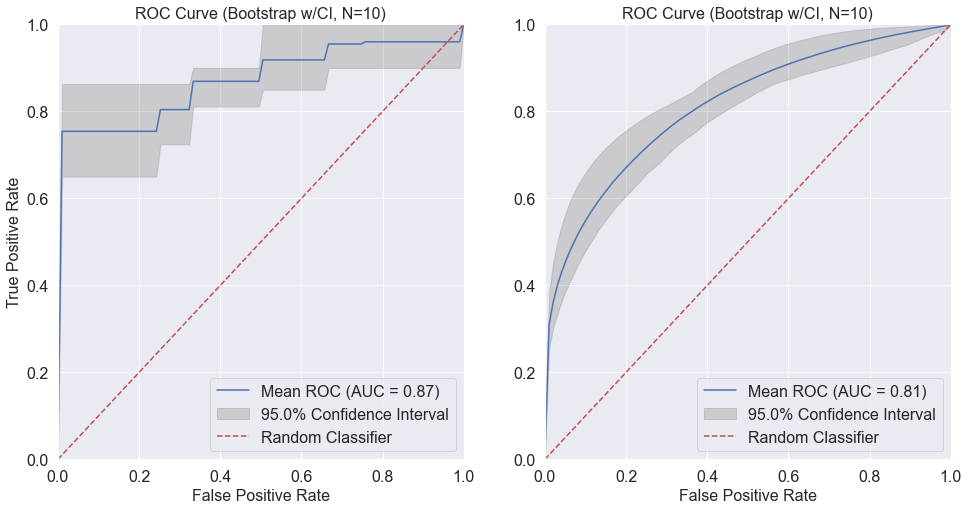

In [238]:

plt.rcParams.update({'font.size': 20})

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Calculate the confidence interval for TPRs
confidence_level = 0.95
lower_percentile = (1 - confidence_level) / 2 * 100
upper_percentile = (1 + confidence_level) / 2 * 100

# Plot ROC curve and confidence intervals
fig, ax = plt.subplots(1,2,figsize=(16, 8))

subj_tprs_upper = np.percentile(mean_subj_tprs, upper_percentile, axis=0)
subj_tprs_lower = np.percentile(mean_subj_tprs, lower_percentile, axis=0)
mean_subj_auc = auc(mean_fprs, mean_subj_tpr)


ax[0].plot(mean_fprs, mean_subj_tpr, color='b', label=f'Mean ROC (AUC = {mean_subj_auc:.2f})')
ax[0].fill_between(mean_fprs, subj_tprs_lower, subj_tprs_upper, color='grey', alpha=0.3, label=f'{confidence_level * 100:.1f}% Confidence Interval')
ax[0].plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title(f'ROC Curve (Bootstrap w/CI, N={n_bootstrap_iterations})')
ax[0].legend(loc='lower right')

epoch_tprs_upper = np.percentile(mean_epoch_tprs, upper_percentile, axis=0)
epoch_tprs_lower = np.percentile(mean_epoch_tprs, lower_percentile, axis=0)
mean_epoch_auc = auc(mean_fprs, mean_epoch_tpr)

ax[1].plot(mean_fprs, mean_epoch_tpr, color='b', label=f'Mean ROC (AUC = {mean_epoch_auc:.2f})')
ax[1].fill_between(mean_fprs, epoch_tprs_lower, epoch_tprs_upper, color='grey', alpha=0.3, label=f'{confidence_level * 100:.1f}% Confidence Interval')
ax[1].plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_title(f'ROC Curve (Bootstrap w/CI, N={n_bootstrap_iterations})')
ax[1].legend(loc='lower right')

plt.show()


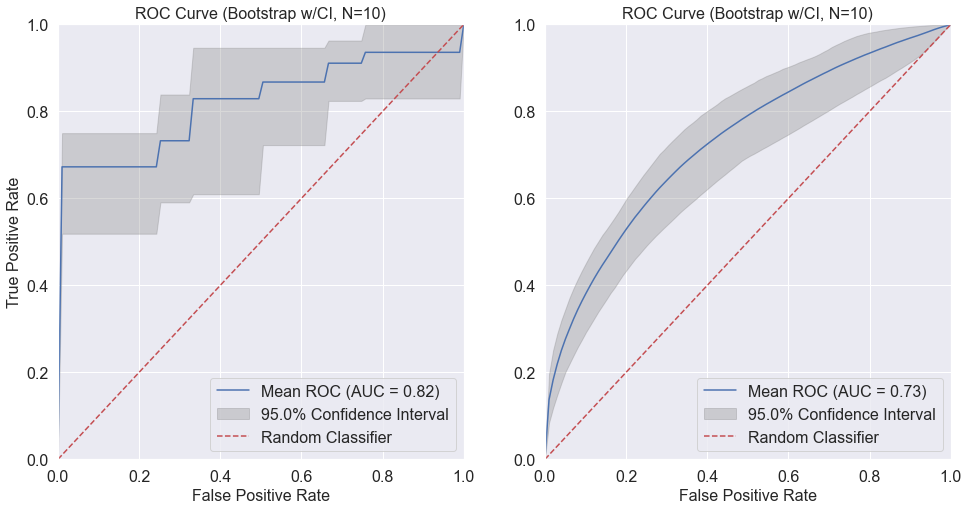

In [242]:
# Logistic Regression
plt.rcParams.update({'font.size': 20})

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Calculate the confidence interval for TPRs
confidence_level = 0.95
lower_percentile = (1 - confidence_level) / 2 * 100
upper_percentile = (1 + confidence_level) / 2 * 100

# Plot ROC curve and confidence intervals
fig, ax = plt.subplots(1,2,figsize=(16, 8))

subj_tprs_upper = np.percentile(mean_subj_tprs, upper_percentile, axis=0)
subj_tprs_lower = np.percentile(mean_subj_tprs, lower_percentile, axis=0)
mean_subj_auc = auc(mean_fprs, mean_subj_tpr)


ax[0].plot(mean_fprs, mean_subj_tpr, color='b', label=f'Mean ROC (AUC = {mean_subj_auc:.2f})')
ax[0].fill_between(mean_fprs, subj_tprs_lower, subj_tprs_upper, color='grey', alpha=0.3, label=f'{confidence_level * 100:.1f}% Confidence Interval')
ax[0].plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title(f'ROC Curve (Bootstrap w/CI, N={n_bootstrap_iterations})')
ax[0].legend(loc='lower right')

epoch_tprs_upper = np.percentile(mean_epoch_tprs, upper_percentile, axis=0)
epoch_tprs_lower = np.percentile(mean_epoch_tprs, lower_percentile, axis=0)
mean_epoch_auc = auc(mean_fprs, mean_epoch_tpr)

ax[1].plot(mean_fprs, mean_epoch_tpr, color='b', label=f'Mean ROC (AUC = {mean_epoch_auc:.2f})')
ax[1].fill_between(mean_fprs, epoch_tprs_lower, epoch_tprs_upper, color='grey', alpha=0.3, label=f'{confidence_level * 100:.1f}% Confidence Interval')
ax[1].plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_title(f'ROC Curve (Bootstrap w/CI, N={n_bootstrap_iterations})')
ax[1].legend(loc='lower right')

plt.show()


In [188]:
mean_subj_tprs

,Class,probs
Subject,,
35,0,0.443410
43,0,0.443370
44,0,0.443309
54,1,0.443581
59,1,0.443531


In [35]:
train_ann = train_ann_df[train_ann_df["Subject"].isin(train_subjects)]

In [36]:
print("avg_val_score: %4f" % (np.mean(val_scores)))

avg_val_score: 0.818050


In [33]:
metadata_df = pd.DataFrame()
c = 0
for anns, clinvars in metadata:
    curr_df = pd.concat([anns, clinvars], axis=1)
    curr_df['preds'] = preds[c]
    print(np.unique(preds[c]))
    metadata_df = pd.concat([metadata_df, curr_df], axis=0)
    c+=1

[0.46447812 0.46593757 0.56416585]
[0.39186049 0.45638144]
[0.29695469 0.63715082]
[0.40095234]
[0.41048571 0.51030585]
[0.31268475 0.65262139]
[0.41944617 0.5192051 ]
[0.38415936 0.44140616 0.48425421]
[0.43885312 0.459871   0.53853341]
[0.40935597 0.41806632 0.45950551 0.50918496]


In [148]:
metadata_df.to_csv('spqr_v20230331.csv', index=False)


In [149]:
curr_df

,Subject,Class,Age,Latency,Subject,preds
17040,8,1,122.0,56.0,8,0.503671
17041,8,1,122.0,56.0,8,0.503671
17042,8,1,122.0,56.0,8,0.503671
17043,8,1,122.0,56.0,8,0.503671
17044,8,1,122.0,56.0,8,0.503671
...,...,...,...,...,...,...
107725,45,0,230.0,3.0,45,0.403794
107726,45,0,230.0,3.0,45,0.403794
107727,45,0,230.0,3.0,45,0.403794
107728,45,0,230.0,3.0,45,0.403794


In [ ]:
# Iterate through kfolds
all_shap_v = []
all_Xv = []
all_subjs = []
all_yp = []
all_yv = []
all_ictal = []
kfolds_dir = 'kfolds_all_noTD_cork_huh_ucsf'


for kf in range(10):
    print('#####', kf)
    Xv_lst, yp_lst, yv_lst, y_test_ictal_lst, subj_lst, raw_data_cols, curr_shaps = run_kf(kfold=kf, kfolds_dir=kfolds_dir)
    

    raw_data_cols_plusArt = raw_data_cols + ['artifact_score']
    Xv_df = pd.DataFrame(data=Xv_lst, columns=raw_data_cols_plusArt)
    Xv_df = Xv_df.fillna(0)
    all_Xv.append(Xv_df)

    all_shap_v.append(curr_shaps)
    all_subjs.append(subj_lst)
    all_yp.append(yp_lst)
    all_yv.append(yv_lst)
    all_ictal.append(y_test_ictal_lst)
    

In [19]:
temp_features[0].shape

(70, 30, 21, 6)